Because the data I am working on isn't labeled I decided to go with an unsupervised approach where I am going to cluster the data and then predict the cluster for a a given list of 2 songs by the user and use that cluster only for recommendations.

Two different types of clustering algorithms were chosen that can be split in 2 groups: one group that don’t have a number of cluster as an input parameters (density models) and the other that uses a k number of clusters as input parameter (centroid based models).

- Density model: DBSCAN
- Centroid based model: KMeans

I am going to score the resulting clusters with 3 different metrics: Silhouette and Davis-Bouldin.
- The Silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
- The Davies-Bouldin index, is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. The minimum score is zero, with lower values indicating better clustering. The lower the average similarity is, the better the clusters are separated and the better is the result of the clustering performed.

#### DBSCAN
DBSCAN is a density-based clustering algorithm that forms clusters of dense regions of data points ignoring the low-density areas (considering them as noise).
###### Advantages
- Works well for noisy datasets.
- Can identity Outliers easily.
- Clusters can take any irregular shape unlike K-Means where clusters are more or less spherical.
###### Disadvantages
- Does not work very well for sparse datasets or datasets with varying density.
- Sensitive to eps parameter.
- Not partitionable for multiprocessor systems.

#### K-Means
K-Means cluster is one of the most commonly used unsupervised machine learning clustering techniques. It is a centroid based clustering technique that needs you decide the number of clusters (centroids) and randomly places the cluster centroids to begin the clustering process
###### Advantages
- Easy to understand and implement.
- Can handle large datasets well.
###### Disadvantages
- Sensitive to number of clusters/centroids chosen.
- Does not work well with outliers.
- Gets slow as the number of dimensions increases.



**As always, the data is scaled before doing any processing**

# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import spotify_keys_copy as keys

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict


---
# Data Projection
For this data, TSNE (T-distributed Stochastic Neighbor Embedding) is used to project the data in a 2D space. This big blob is a 2D representation of all the songs in the data set.

In [3]:
df = pd.read_csv('../data/JOINT.csv')

df.drop(columns = ['time_signature'], inplace = True)

# Drop rows containing null values as they aren't a significant number
df.dropna(inplace = True)
df.drop_duplicates(['id'], inplace = True)

#change release_date to datetime
df['release_year'] = df['release_date'].apply(lambda x: x.split('-')[0])
df.drop(columns = ['release_date'], inplace = True)

#Change duration in ms to seconds and drop duration_ms column
df['duration'] = df['duration_ms'].apply(lambda x: round(x/1000))
df.drop(columns = ['duration_ms'], inplace = True)

df.head(1)

,id,title,all_artists,popularity,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,release_year,duration
0,2ROJOb98GorxStuOuZWcGd,Have You Ever Loved A Woman?,Derek & The Dominos,61,0.303,0.648,0,-6.795,1,0.642,0.053,0.407,0.644,170.379,1970,413


In [4]:
#Scaling Data.

df_numerical = df.select_dtypes(np.number)

scaler = StandardScaler().fit(df_numerical) #Only Scale numerical columns
scaled_data = scaler.transform(df_numerical)

features_df = pd.DataFrame(scaled_data)
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.847004,-1.745007,-0.071997,-1.492832,0.244160,0.743630,1.327572,-0.240640,1.457910,0.425269,1.745351,2.354655
1,0.687759,0.290161,-0.721349,-0.932559,-0.629819,0.743630,1.241378,-0.436960,-0.025961,1.662448,-0.164394,0.271351
2,0.687759,-1.443053,1.094275,-0.932559,0.477342,0.743630,-0.638986,-0.196151,0.841839,-0.045658,0.864510,0.518743
3,0.647947,1.105436,-0.708533,-0.372286,0.166231,0.743630,0.843557,-0.355940,-0.483046,1.295285,-0.007200,0.010938
4,-1.581491,-0.229199,-0.635908,1.028398,0.239315,-1.344755,-0.058168,0.623181,-0.875212,0.098015,-1.099706,1.195817


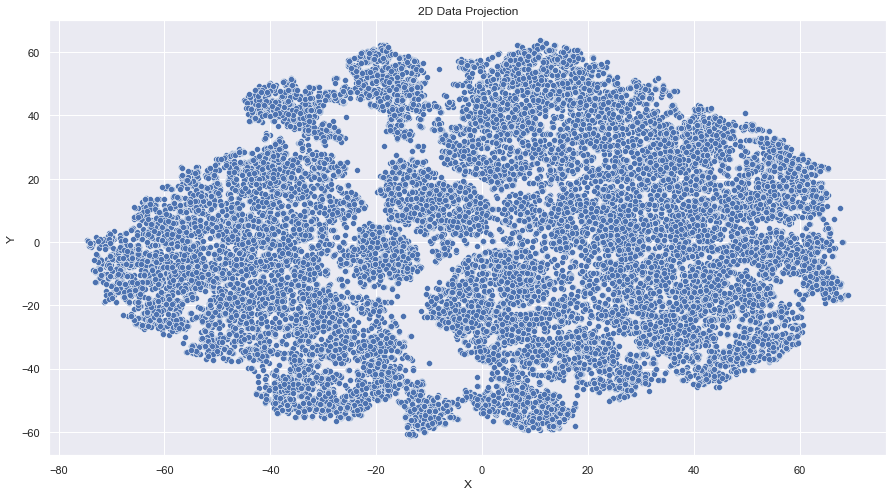

In [5]:
#Instantiating TSNE
tsne = TSNE(n_components=2, random_state=42)


tsne_df = pd.DataFrame(tsne.fit_transform(scaled_data), columns = ['X', 'Y'] )

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x= 'X', y= 'Y',data= tsne_df).set(title= '2D Data Projection');

---
# Clustering and evaluation

### DBSCAN

"eps" is a value that deals with the radius of the clusters you are trying to find. We can find a suitable value for "eps" by calculating the distance to the nearest n points for each point, sorting and plotting the results. After, we look to see where the change is most pronounced and select that as epsilon.

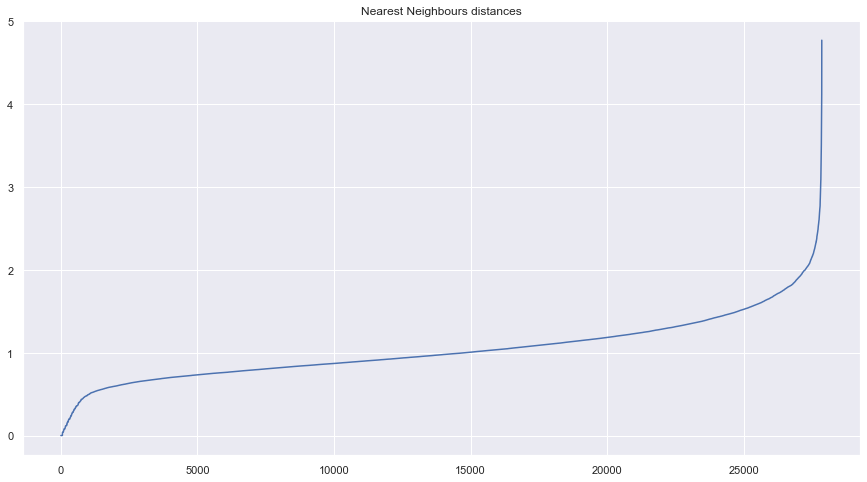

In [64]:
# Selection of best eps: https://medium.com/p/3100091cfbc
nn = NearestNeighbors(n_neighbors=2)
neihbors = nn.fit(features_df)
distances, indices = neihbors.kneighbors(features_df)

#Next, we sort and plot results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(15, 8))
plt.plot(distances)
plt.title('Nearest Neighbours distances');

The change is most pronounced around 2, so let's examine the scores around eps=2.

In [66]:
# Compute DBSCAN looking for the best "eps" value
for i in range(18, 30, 1):
    eps = i/10
    db = DBSCAN(eps = eps).fit(features_df)
    labels = db.labels_
    number_clusters = len(np.unique(labels))
    if number_clusters > 1:
        print(f'Eps={eps}: est_clusters = {number_clusters}    silhouette_score = {silhouette_score(features_df, labels)}    davies_bouldin_score = {davies_bouldin_score(features_df, labels)}')
    else:
        print(f'Eps={eps}: {number_clusters}, NO scores')

Eps=1.8: est_clusters = 17    silhouette_score = -0.04328213028308365    davies_bouldin_score = 1.7686355144164754
Eps=1.9: est_clusters = 7    silhouette_score = 0.046590248122024974    davies_bouldin_score = 1.9388381408402768
Eps=2.0: est_clusters = 5    silhouette_score = 0.050912341687881245    davies_bouldin_score = 2.3434733902164244
Eps=2.1: est_clusters = 8    silhouette_score = 0.061500928849121665    davies_bouldin_score = 1.9438737882143027
Eps=2.2: est_clusters = 2    silhouette_score = 0.3535178062101524    davies_bouldin_score = 2.227633594948171
Eps=2.3: est_clusters = 2    silhouette_score = 0.3768460622971972    davies_bouldin_score = 2.0698345378768686
Eps=2.4: est_clusters = 2    silhouette_score = 0.39659357973236753    davies_bouldin_score = 1.9759134613734923
Eps=2.5: est_clusters = 2    silhouette_score = 0.42132538730787883    davies_bouldin_score = 1.805455285341438
Eps=2.6: est_clusters = 2    silhouette_score = 0.4504730129145494    davies_bouldin_score = 1.

Because the higher the Silhouette score is, the better the object is well matched to its own cluster and the Davies-Bouldin index, is defined as the average similarity measure of each cluster with it's most similar cluster, the higher the "eps" is the better these results are going to be. The significant observation after this computation is that 2 is the optimal estimated number of clusters.

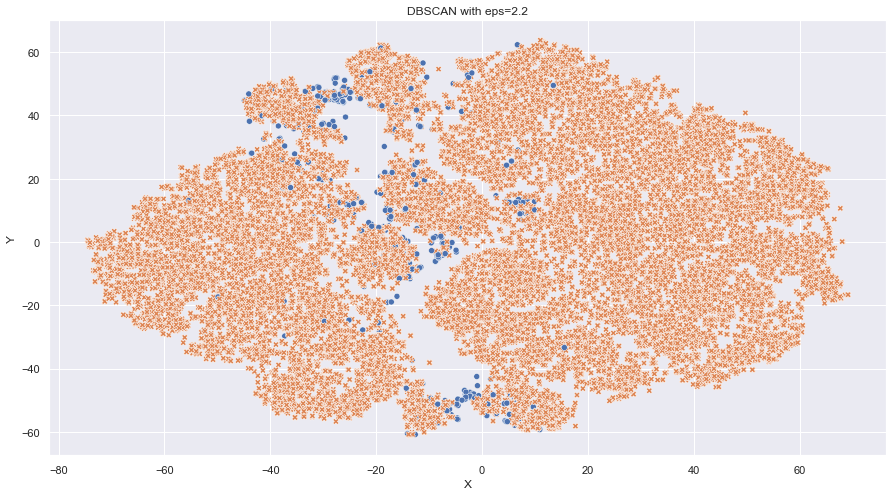

In [67]:
# Plotting DBSCAN choosing eps = 2.2 as it is where a significant improvement from the scores occurs.

db = DBSCAN(eps = 2.2).fit(features_df)

tsne_df['cluster'] = pd.Categorical(db.labels_) #Categorical class classifies by unique values

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data= tsne_df, legend=None).set(title= 'DBSCAN with eps=2.2');

### K-Means

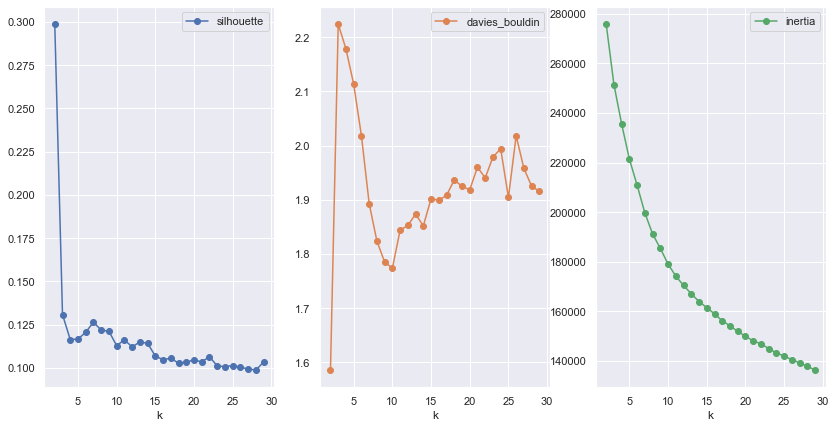

In [78]:
# Plot K-Means scores 

scores = []
for k in range(2,30):
    km = KMeans(n_clusters = k).fit(features_df)
    labels = km.labels_
    inertia = km.inertia_

    silhouette = silhouette_score(features_df, labels)
    davies_bouldin = davies_bouldin_score(features_df, labels)
    scores.append([k, silhouette, davies_bouldin, inertia])
    
score_df = pd.DataFrame(scores, columns=['k', 'silhouette', 'davies_bouldin', 'inertia'])
axs = score_df.plot(x='k', subplots=True, layout=(1,3), figsize=(14,7), marker='o')

In [83]:
# Compute K-Means looking for the best "k" value

best_k = 0
best_sil = 0 #we are going to determine the best k with silhouette_score as an indicator
best_dav = 100 #To initialize and keep saving always the lowest
for k in range(3,30): #starting at 3 because of graph telling us that 2 is going to mess up the exploration
    km = KMeans(n_clusters = k).fit(features_df)
    labels = km.labels_
    number_clusters = len(np.unique(labels))
    if number_clusters > 1:
        if davies_bouldin_score(features_df, labels) < best_dav:
            print(f'Clusters = {number_clusters} and silhouette_score = {silhouette_score(features_df, labels)} and davies_bouldin_score = {davies_bouldin_score(features_df, labels)}')
            best_k = k
            best_sil = silhouette_score(features_df, labels)
            best_dav = davies_bouldin_score(features_df, labels)
            
print(f'Best k={best_k}')
print(f'Best silhouette_score={best_sil}')
print(f'Best davies_bouldin_score={best_dav}')

Clusters = 3 and silhouette_score = 0.1308459837081588 and davies_bouldin_score = 2.22424201144414
Clusters = 4 and silhouette_score = 0.11634184576915448 and davies_bouldin_score = 2.17835424258753
Clusters = 5 and silhouette_score = 0.1165915537038029 and davies_bouldin_score = 2.113067216857571
Clusters = 6 and silhouette_score = 0.12065480501911563 and davies_bouldin_score = 2.017815873085152
Clusters = 7 and silhouette_score = 0.12634143746654364 and davies_bouldin_score = 1.8934124335568983
Clusters = 8 and silhouette_score = 0.12177953425477861 and davies_bouldin_score = 1.823843689022638
Clusters = 10 and silhouette_score = 0.11281057437962341 and davies_bouldin_score = 1.7740679078724688
Best k=10
Best silhouette_score=0.11281057437962341
Best davies_bouldin_score=1.7740679078724688


Prioritizing the quality of separation between clusters, as they represent types of similar songs, the Davies-Bouldin Index is going to be the final indicator for the k selection. From the computated results and the graphs above, it is clear that the optimal value of k for the K-Means algorithm is 10.

In [96]:
print(features_df.shape)
features_df.head()

(27859, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.847004,-1.745007,-0.071997,-1.492832,0.244160,0.743630,1.327572,-0.240640,1.457910,0.425269,1.745351,2.354655
1,0.687759,0.290161,-0.721349,-0.932559,-0.629819,0.743630,1.241378,-0.436960,-0.025961,1.662448,-0.164394,0.271351
2,0.687759,-1.443053,1.094275,-0.932559,0.477342,0.743630,-0.638986,-0.196151,0.841839,-0.045658,0.864510,0.518743
3,0.647947,1.105436,-0.708533,-0.372286,0.166231,0.743630,0.843557,-0.355940,-0.483046,1.295285,-0.007200,0.010938
4,-1.581491,-0.229199,-0.635908,1.028398,0.239315,-1.344755,-0.058168,0.623181,-0.875212,0.098015,-1.099706,1.195817


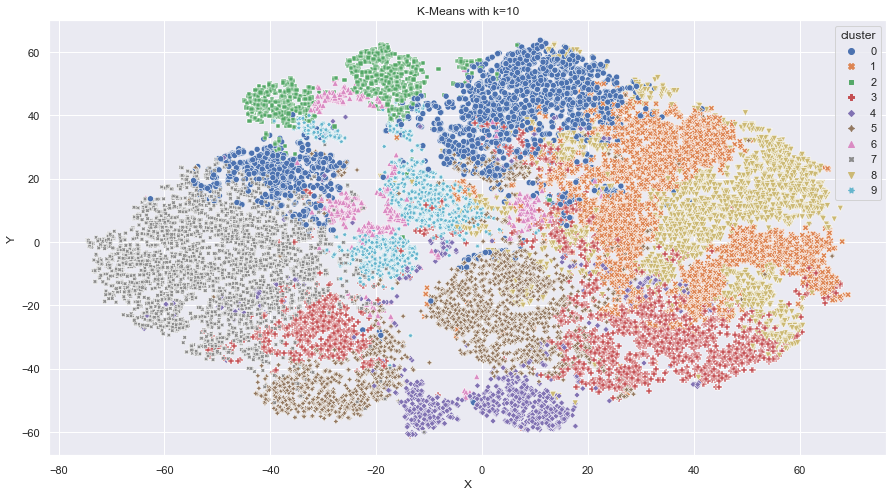

In [6]:
# Plotting K-Means k=10
km = KMeans(n_clusters = 10).fit(features_df)
tsne_df['cluster'] = pd.Categorical(km.labels_)

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data= tsne_df).set(title= 'K-Means with k=10');

---
# Model selection
Prioritizing Davies-Bouldin Index as the indicator for our model selection, K-Means is the best model to create significant clusters. For the density model, the clustering hasn't worked as expected even after fine tuning the "eps" and the results weren't great either. 

Davies-Bouldin Scores:

- DBSCAN: 2.22
- KMeans: 1.77


---
# Music recommender

The music recommendation is going to be based on clustering. Each cluster has similar music in it and this is a key part of our recommender system because each cluster will serve as a boundary.By having a boundary, the risk of recommending music that it is unrelated is eliminated.

Once the user inputs two songs as seed songs for a playlist with similar songs, with our previously trained model, a target vector will be created calculating the feature means of those songs and it will be able to predict in which cluster the user is going to fall and recommend similar songs from that cluster.

The model will use the "cosine" similarity metric to recommend the top 10 most similar songs from the dataset. Cosine similarity is a metric used to measure similarity between two inputs. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.

In [8]:

client_id = keys.SPOTIFY_CLIENT_ID
client_secret = keys.SPOTIFY_CLIENT_SECRET

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

def find_song(lista):
    inp = pd.DataFrame() 
    for (title, artist) in lista:
        song_data = defaultdict()
        #results = sp.search(q= 'track: {}'.format(title), limit=1)
        results = sp.search(q = 'track: {} artist: {}'.format(title, artist), limit=1, offset=0, type='track')
        if results['tracks']['items'] == []:
            return None

        results = results['tracks']['items'][0]
        track_id = results['id']
        audio_features = sp.audio_features(track_id)[0]

        song_data['title'] = [title]
        song_data['artist'] = [artist]
        song_data['duration_ms'] = [results['duration_ms']]
        song_data['popularity'] = [results['popularity']]

        for key, value in audio_features.items():
        #key = feature and value = value of feature
            song_data[key] = value
    
        df = pd.DataFrame(song_data)
    
        #CAMBIOS DE MI FEATURE ENGINEERING    
        df.drop(columns = ['time_signature'], inplace = True)

        # Drop rows containing null values as they aren't a significant number
        df.dropna(inplace = True)
        df.drop_duplicates(['id'], inplace = True)

        #Change duration in ms to seconds and drop duration_ms column
        df['duration'] = df['duration_ms'].apply(lambda x: round(x/1000))
        df.drop(columns = ['duration_ms'], inplace = True)
        inp = pd.concat([inp, df])
    return inp


list_of_songs = []
while len(list_of_songs)<2:
    input_song = input('Enter song name:')
    input_artist = input('Enter artist name:')
    list_of_songs.append((input_song, input_artist))

y = find_song(list_of_songs)

#scaled_y = scaler.transform(np.array(y).reshape(1,-1))
y.drop(columns = ['speechiness'], inplace = True)
y = y.select_dtypes(np.number).mean()

scaled_y = scaler.transform(np.array(y).reshape(1,-1))

def recommend_songs(feats_df, track_data, y, n):
    
    feats_df['cluster'] = pd.Categorical(km.labels_)
    user_cluster = km.predict(y)
    
    df_slice = feats_df[feats_df['cluster']==user_cluster[0]]
    df_slice = df_slice.drop(['cluster'], axis=1)
    indices = feats_df[feats_df['cluster']==user_cluster[0]].reset_index()['index'].to_numpy()
    
    scaled_data = df_slice.to_numpy()
    
    simi = cdist(scaled_data, y, metric='cosine').argsort(axis=None)[:n]

    rec_songs = track_data.iloc[simi]
    
    return rec_songs[['title', 'all_artists']]

recommend_songs(feats_df = features_df , track_data = df, y = scaled_y, n = 10)

KeyboardInterrupt: Interrupted by user

In [9]:

client_id = keys.SPOTIFY_CLIENT_ID
client_secret = keys.SPOTIFY_CLIENT_SECRET

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

def find_song(lista):
    inp = pd.DataFrame() 
    for (title, artist) in lista:
        song_data = defaultdict()
        #results = sp.search(q= 'track: {}'.format(title), limit=1)
        results = sp.search(q = 'track: {} artist: {}'.format(title, artist), limit=1, offset=0, type='track')
        if results['tracks']['items'] == []:
            return None

        results = results['tracks']['items'][0]
        track_id = results['id']
        audio_features = sp.audio_features(track_id)[0]

        song_data['title'] = [title]
        song_data['artist'] = [artist]
        song_data['duration_ms'] = [results['duration_ms']]
        song_data['popularity'] = [results['popularity']]

        for key, value in audio_features.items():
        #key = feature and value = value of feature
            song_data[key] = value
    
        df = pd.DataFrame(song_data)
    
        #CAMBIOS DE MI FEATURE ENGINEERING    
        df.drop(columns = ['time_signature'], inplace = True)

        # Drop rows containing null values as they aren't a significant number
        df.dropna(inplace = True)
        df.drop_duplicates(['id'], inplace = True)

        #Change duration in ms to seconds and drop duration_ms column
        df['duration'] = df['duration_ms'].apply(lambda x: round(x/1000))
        df.drop(columns = ['duration_ms'], inplace = True)
        inp = pd.concat([inp, df])
    return inp


list_of_songs = []
while len(list_of_songs)<2:
    input_song = input('Enter song name:')
    input_artist = input('Enter artist name:')
    list_of_songs.append((input_song, input_artist))

y = find_song(list_of_songs)

#scaled_y = scaler.transform(np.array(y).reshape(1,-1))
y.drop(columns = ['speechiness'], inplace = True)

Enter song name: Hello
Enter artist name: Adele
Enter song name: Lantern
Enter artist name: Les gordon


In [10]:
y.dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'